In [2]:
import pandas as pd
from io import StringIO


csv_data = '''A,B,C,D
1,2,3,4
5,6,,8
10,,12,13'''

csv_data = unicode(csv_data)
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,8
2,10,NaN,12,13


In [3]:
df.isnull().sum()

A    0
B    1
C    1
D    0
dtype: int64

In [4]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  nan,  12.,  13.]])

In [5]:
df.dropna()

,A,B,C,D
0,1,2,3,4


In [6]:
df.dropna(axis=1)

,A,D
0,1,4
1,5,8
2,10,13


In [8]:
df.dropna(how='all') #all columns are NaN

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,8
2,10,NaN,12,13


In [9]:
df.dropna(thresh=4) #at least 4 non-NaN values

,A,B,C,D
0,1,2,3,4


In [10]:
df.dropna(subset=['C']) #Non appears in C

,A,B,C,D
0,1,2,3,4
2,10,NaN,12,13


In [11]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,   4. ,  12. ,  13. ]])

In [26]:
df = pd.DataFrame([
    ['green', 'M', 10, 'c1'],
    ['red', 'L', 30, 'c2'],
    ['blue', 'XL', 15, 'c3'],
])
df.columns = ['color', 'size', 'price', 'classL']
df

,color,size,price,classL
0,green,M,10,c1
1,red,L,30,c2
2,blue,XL,15,c3


In [15]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classL'].values)
y

array([0, 1, 2])

In [23]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X[:, 1] = color_le.fit_transform(X[:, 1])
X

array([[1, 1, 10],
       [2, 0, 30],
       [0, 2, 15]], dtype=object)

In [24]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0.,   1.,   0.,   1.,  10.],
       [  0.,   0.,   1.,   0.,  30.],
       [  1.,   0.,   0.,   2.,  15.]])

In [27]:
pd.get_dummies(df[['price', 'color', 'size']])

,"(c, o, l, o, r)","(p, r, i, c, e)","(s, i, z, e)"
0,0,1,0
1,1,0,0
2,0,0,1


In [56]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# split model into traing and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# MinMaxScaler - normalization -> [0, 1], StandardScaler -> mean = 0, stdev = 1, maintains info about outliers 
# (fit only on training and use it for test)
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)


In [39]:
# feature selection algorithm: SBS
import numpy as np
from sklearn import clone 
from itertools import combinations

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.estimator = estimator
        self.k_features = k_features
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                            random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices = tuple(range(dim))
        self.subsets = [self.indices]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices)
        
        self.scores = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices = subsets[best]
            self.subsets.append(self.indices)
            
            dim -= 1
            
            self.scores.append(scores[best])
            
        self.k_score = self.scores[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices]
        
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        return self.scoring(y_test, y_pred)
    

In [51]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_scaled, y_train)

<__main__.SBS instance at 0x116416c68>

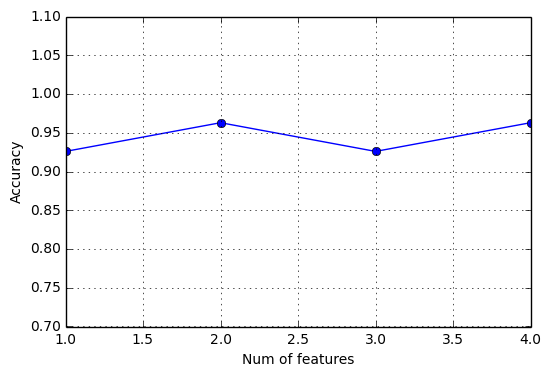

In [52]:
k_feat = [len(k) for k in sbs.subsets]
plt.plot(k_feat, sbs.scores, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Num of features')
plt.ylim([0.7, 1.1])
plt.grid()
plt.show()

In [53]:
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9555555555555556

In [54]:
knn.fit(X_train_scaled[:, sbs.subsets[1]], y_train)
knn.score(X_test_scaled[:, sbs.subsets[1]], y_test)

0.9555555555555556

In [57]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
print(importances)

[ 0.50129363  0.49870637]


In [58]:
X_selected = forest.transform(X_train, threshold=0.5)
X_selected.shape

/usr/local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(105, 1)